In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import plotly.express as px
from functions import redshift_connection, create_redshift_df, train_evaluate_model, calculate_mean_shap_values
from sklearn.metrics import accuracy_score, confusion_matrix

/Users/eben.opperman/Documents/Projects/match_event_weighting/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results = redshift_connection()
df_redshift_data_all = create_redshift_df(results)

Connection to Redshift database successful
Database connection is active.
Redshift connection closed


In [3]:
df_redshift_data_all.to_csv('redshift_data.csv', index=False)

In [4]:
df_redshift_data_all.shape

(182, 27)

In [5]:
df_redshift_data_all_clean = df_redshift_data_all.dropna()

In [6]:
df_redshift_data_all_clean.shape

(182, 27)

In [7]:
df_redshift_data_all_clean.head()


,fixture_mid,home_team,away_team,home_score,away_score,team_name,kick_errors,rucks_won,rucks_lost,total_linebreaks,...,total_offloads,total_carries,total_carry_metres,total_carries_dominant,total_turnovers_conceded,total_penalties_conceded,total_carry_metres_post_contact,ruck_arrivals_attack_first2,ruck_arrivals_defence_first2,won_lost
0,01506546-a187-47f0-860d-db4b999d6eb4,Hurricanes,Blues,29,21,Blues,1,113,4,4,...,14,161,602,90,17,8,260,0,0,0
1,01506546-a187-47f0-860d-db4b999d6eb4,Hurricanes,Blues,29,21,Hurricanes,1,78,3,9,...,8,112,474,44,14,11,248,0,0,1
2,0235f1fc-5c68-4456-9ec3-da0ff022d3b8,NSW Waratahs,Blues,10,12,Blues,0,92,3,6,...,14,126,550,82,16,9,226,0,0,1
3,0235f1fc-5c68-4456-9ec3-da0ff022d3b8,NSW Waratahs,Blues,10,12,NSW Waratahs,0,89,4,3,...,8,121,475,70,12,15,283,0,0,0
4,044a13e8-6edc-4146-9744-47f80713bc0f,ACT Brumbies,Highlanders,32,16,ACT Brumbies,2,105,2,8,...,8,136,388,56,12,13,318,198,68,1


In [8]:

# df_redshift_data_all = pd.read_csv('redshift_data.csv')
# df_redshift_data_all.shape

In [9]:
df_redshift_data_all_clean['score_difference'] = df_redshift_data_all_clean['home_score'] - df_redshift_data_all_clean['away_score']

# Remove outliers based on the 'score_difference' column
z_scores = np.abs(stats.zscore(df_redshift_data_all_clean['score_difference']))
df_redshift_data_all_clean = df_redshift_data_all_clean[z_scores < 3]

print("\nData after removing outliers:")
print(df_redshift_data_all_clean.describe())
df_redshift_data_all_clean.shape


Data after removing outliers:
       home_score  away_score  kick_errors   rucks_won  rucks_lost  \
count  182.000000  182.000000   182.000000  182.000000  182.000000   
mean    31.417582   22.219780     1.291209   83.714286    3.126374   
std     13.185515   11.361272     1.160029   21.470414    1.802536   
min      3.000000    0.000000     0.000000   30.000000    0.000000   
25%     22.000000   13.250000     0.000000   69.250000    2.000000   
50%     31.000000   21.000000     1.000000   83.500000    3.000000   
75%     40.000000   29.000000     2.000000   96.750000    4.000000   
max     68.000000   53.000000     5.000000  139.000000    9.000000   

       total_linebreaks  total_tries  total_supported_breaks  \
count        182.000000   182.000000              182.000000   
mean           5.763736     3.604396                2.752747   
std            2.840940     2.072600                2.428962   
min            1.000000     0.000000                0.000000   
25%            4.0

(182, 28)

In [10]:
# Define the features and target variable
X = df_redshift_data_all_clean[['kick_errors',
            'rucks_won',
            'rucks_lost',
            'total_linebreaks',
            'total_tries',
            'total_supported_breaks',
            'total_defenders_beaten',
            'total_jackals_success',
            'total_intercepts',
            'total_tackles_made',
            'total_tackles_missed',
            'total_offloads',
            'total_carries',
            'total_carry_metres',
            'total_carries_dominant',
            'total_turnovers_conceded',
            'total_penalties_conceded', 
            'total_carry_metres_post_contact',
            'ruck_arrivals_attack_first2',
            'ruck_arrivals_defence_first2']]
y = df_redshift_data_all_clean['won_lost']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random forest

In [11]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf, accuracy_rf, conf_matrix_rf, feature_importance_rf = train_evaluate_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, feature_names=X.columns)

# Create a DataFrame for feature importance
random_forest_feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_rf': rf.feature_importances_  # Use feature_importances_ for RandomForestClassifier
})

print("Random Forest Accuracy:", accuracy_rf)
print(feature_importance_rf)
random_forest_feature_importance_df.head()



Feature importance found
Random Forest Accuracy: 0.6486486486486487
                            feature  importance
0                       kick_errors    0.021658
1                         rucks_won    0.051227
2                        rucks_lost    0.055440
3                  total_linebreaks    0.093665
4                       total_tries    0.179885
5            total_supported_breaks    0.071651
6            total_defenders_beaten    0.042135
7             total_jackals_success    0.032591
8                  total_intercepts    0.010480
9                total_tackles_made    0.062753
10             total_tackles_missed    0.056843
11                   total_offloads    0.025982
12                    total_carries    0.040191
13               total_carry_metres    0.048809
14           total_carries_dominant    0.035941
15         total_turnovers_conceded    0.049826
16         total_penalties_conceded    0.046806
17  total_carry_metres_post_contact    0.043272
18      ruck_arrival

,feature,importance_rf
0,kick_errors,0.021658
1,rucks_won,0.051227
2,rucks_lost,0.055440
3,total_linebreaks,0.093665
4,total_tries,0.179885


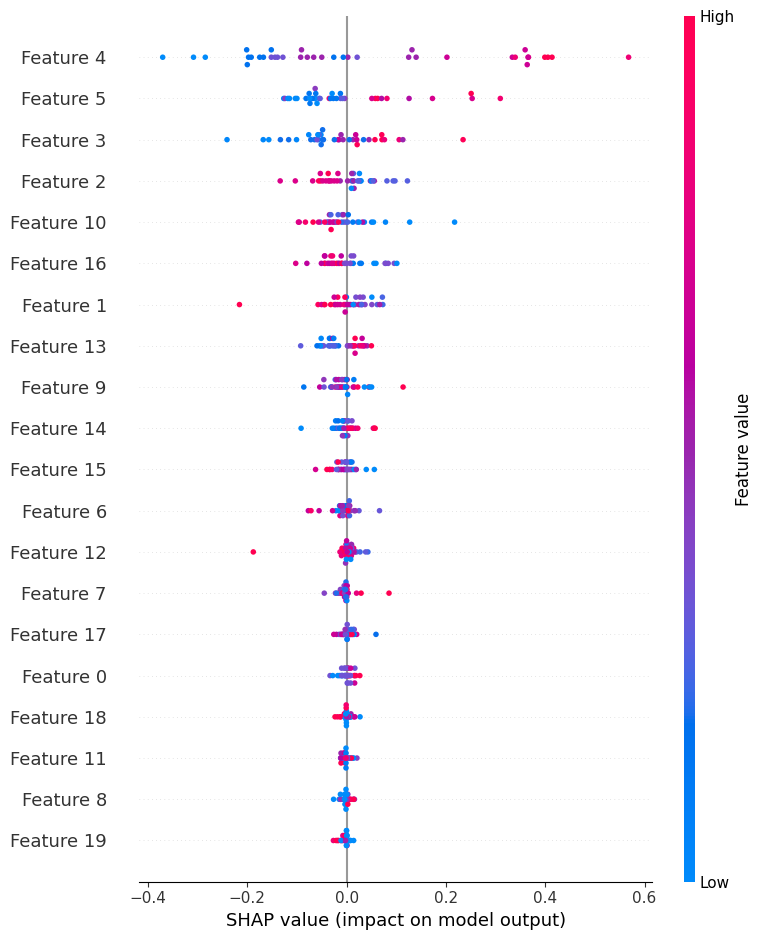

Mean SHAP values for each feature:
kick_errors: 0.0001
rucks_won: 0.0023
rucks_lost: 0.0013
total_linebreaks: -0.0215
total_tries: 0.0355
total_supported_breaks: -0.0062
total_defenders_beaten: -0.0060
total_jackals_success: -0.0023
total_intercepts: -0.0014
total_tackles_made: -0.0047
total_tackles_missed: -0.0064
total_offloads: -0.0012
total_carries: 0.0009
total_carry_metres: -0.0113
total_carries_dominant: -0.0012
total_turnovers_conceded: -0.0040
total_penalties_conceded: -0.0015
total_carry_metres_post_contact: 0.0024
ruck_arrivals_attack_first2: 0.0004
ruck_arrivals_defence_first2: -0.0029


In [12]:
# Create the SHAP Explainer
explainer = shap.Explainer(rf_model.predict, X_train_scaled)

# Calculate SHAP values for test set
shap_values = explainer(X_test_scaled)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test_scaled)

# Calculate mean SHAP values for each feature
mean_shap_values = np.mean(shap_values.values, axis=0)
mean_shap_per_feature = dict(zip(X.columns, mean_shap_values))

print("Mean SHAP values for each feature:")
for feature, mean_shap in mean_shap_per_feature.items():
    print(f"{feature}: {mean_shap:.4f}")

Logistic Regression

In [13]:
# Logistic Regression
lr_model = LogisticRegression()
lr, accuracy_lr, conf_matrix_lr, feature_importance_lr = train_evaluate_model(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, feature_names=X.columns)
print("Logistic Regression Accuracy:", accuracy_lr)
print(feature_importance_lr.head(15))

log_regrssion_feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'coef_lr': lr.coef_[0]
})
log_regrssion_feature_importance_df.head()


Coef found
Logistic Regression Accuracy: 0.8378378378378378
                   feature      coef
0              kick_errors  0.672781
1                rucks_won -0.197052
2               rucks_lost -0.336144
3         total_linebreaks  0.827912
4              total_tries  1.598470
5   total_supported_breaks -0.239027
6   total_defenders_beaten  0.377230
7    total_jackals_success  0.333736
8         total_intercepts  0.303641
9       total_tackles_made -0.004858
10    total_tackles_missed -0.633103
11          total_offloads -0.301902
12           total_carries -0.619055
13      total_carry_metres  0.236862
14  total_carries_dominant  0.351983


,feature,coef_lr
0,kick_errors,0.672781
1,rucks_won,-0.197052
2,rucks_lost,-0.336144
3,total_linebreaks,0.827912
4,total_tries,1.598470


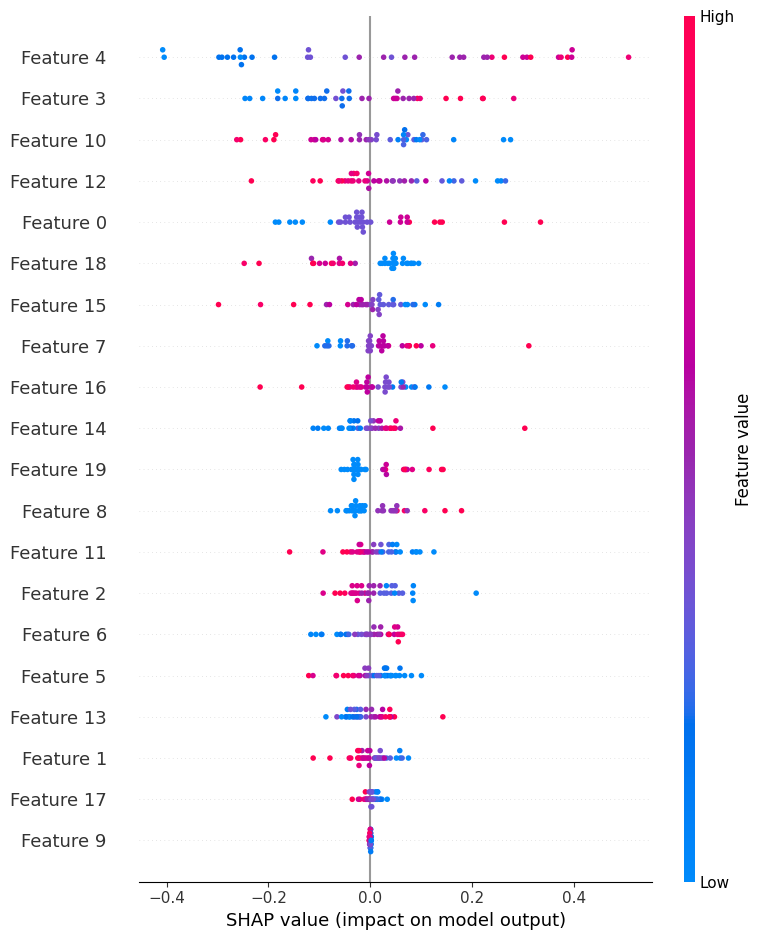

Mean SHAP values for each feature:
kick_errors: -0.0015
rucks_won: 0.0016
rucks_lost: 0.0081
total_linebreaks: -0.0250
total_tries: 0.0335
total_supported_breaks: 0.0069
total_defenders_beaten: -0.0053
total_jackals_success: 0.0115
total_intercepts: 0.0066
total_tackles_made: 0.0001
total_tackles_missed: -0.0008
total_offloads: 0.0103
total_carries: 0.0340
total_carry_metres: -0.0078
total_carries_dominant: 0.0001
total_turnovers_conceded: -0.0066
total_penalties_conceded: 0.0126
total_carry_metres_post_contact: 0.0023
ruck_arrivals_attack_first2: -0.0049
ruck_arrivals_defence_first2: 0.0078


In [14]:
# Create the SHAP Explainer
explainer = shap.Explainer(lr_model.predict, X_train_scaled)

# Calculate SHAP values for test set
shap_values = explainer(X_test_scaled)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test_scaled)

# Calculate mean SHAP values for each feature
mean_shap_values = np.mean(shap_values.values, axis=0)
mean_shap_per_feature = dict(zip(X.columns, mean_shap_values))

print("Mean SHAP values for each feature:")
for feature, mean_shap in mean_shap_per_feature.items():
    print(f"{feature}: {mean_shap:.4f}")

XgBoost

In [15]:

import xgboost as xgb# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_classifier.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = xgb_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("XGBClassifier Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Feature importance
xgboost_feature_importance = pd.DataFrame({'feature': X.columns, 'importance_xgb': xgb_classifier.feature_importances_})
print("Feature Importance:\n", xgboost_feature_importance.sort_values(by='importance_xgb', ascending=False))

XGBClassifier Accuracy: 0.5945945945945946
Confusion Matrix:
 [[12  6]
 [ 9 10]]
Feature Importance:
                             feature  importance_xgb
4                       total_tries        0.264336
16         total_penalties_conceded        0.086250
2                        rucks_lost        0.064667
10             total_tackles_missed        0.062060
1                         rucks_won        0.061036
3                  total_linebreaks        0.059485
5            total_supported_breaks        0.058582
12                    total_carries        0.051582
0                       kick_errors        0.050238
9                total_tackles_made        0.046560
15         total_turnovers_conceded        0.044032
6            total_defenders_beaten        0.035655
11                   total_offloads        0.029892
14           total_carries_dominant        0.025290
17  total_carry_metres_post_contact        0.019437
7             total_jackals_success        0.018655
13            

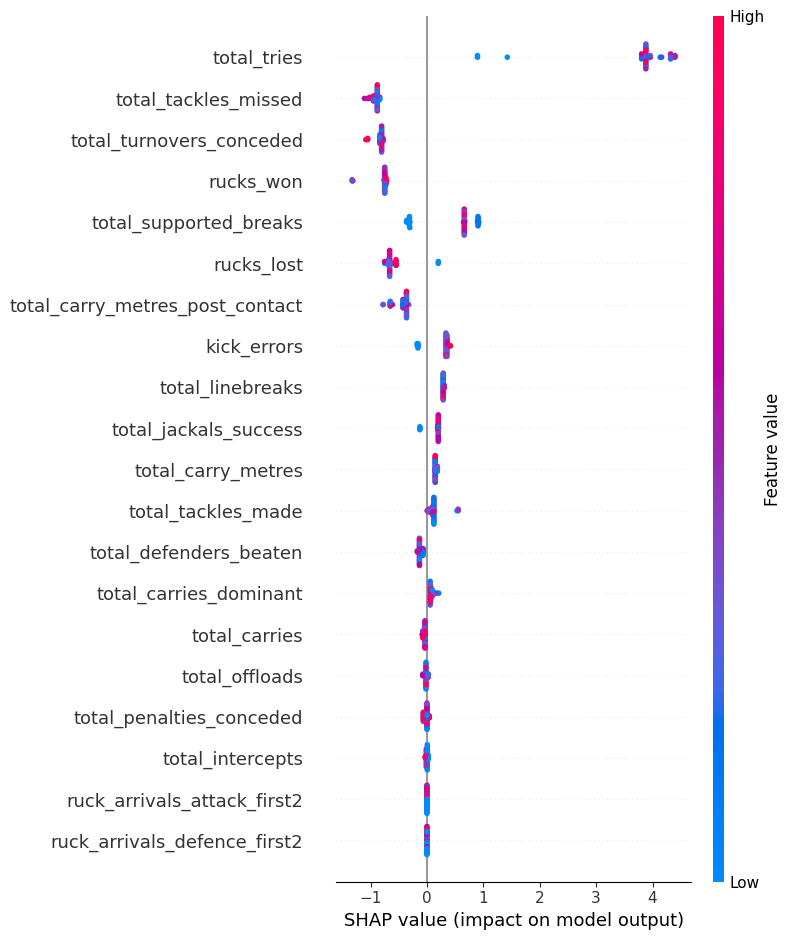

Mean SHAP values for each feature:
kick_errors: 0.2702
rucks_won: -0.7895
rucks_lost: -0.5972
total_linebreaks: 0.2922
total_tries: 3.7513
total_supported_breaks: 0.4569
total_defenders_beaten: -0.1200
total_jackals_success: 0.1644
total_intercepts: 0.0005
total_tackles_made: 0.1375
total_tackles_missed: -0.9091
total_offloads: -0.0127
total_carries: -0.0459
total_carry_metres: 0.1529
total_carries_dominant: 0.0848
total_turnovers_conceded: -0.8294
total_penalties_conceded: -0.0132
total_carry_metres_post_contact: -0.4580
ruck_arrivals_attack_first2: 0.0000
ruck_arrivals_defence_first2: 0.0000


In [16]:
# Create the SHAP Explainer
explainer = shap.Explainer(xgb_classifier)

# Calculate SHAP values for test set
shap_values = explainer(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

mean_shap_values = np.mean(shap_values.values, axis=0)
mean_shap_per_feature = dict(zip(X_test.columns, mean_shap_values))
print("Mean SHAP values for each feature:")
for feature, mean_shap in mean_shap_per_feature.items():
    print(f"{feature}: {mean_shap:.4f}")



In [17]:
# from sklearn.svm import SVC
# # from sklearn.neural_network import MLPClassifier

# # SVM with a linear kernel
# svm_model = SVC(kernel='linear')
# svm, accuracy_svm, conf_matrix_svm, feature_importance_svm = train_evaluate_model(svm_model, X_train_scaled, y_train, X_test_scaled, y_test, feature_names=X.columns)

# # # MLP Neural Network
# # mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
# # mlp, accuracy_mlp, conf_matrix_mlp, _ = train_evaluate_model(mlp_model, X_train_scaled, y_train, X_test_scaled, y_test)
 
# print("SVM Accuracy:", accuracy_svm)
# print(feature_importance_svm)
# # print("MLP Neural Network Accuracy:", accuracy_mlp)
# # print( _ )

In [18]:
# Merge the DataFrames on the 'feature' column
merged_df = log_regrssion_feature_importance_df.merge(random_forest_feature_importance_df, on='feature')
merged_df = merged_df.merge(xgboost_feature_importance, on='feature')
merged_df.to_csv('output/feature_importance_merged.csv', index=False)

